   LengthofCycle EstimatedDayofOvulation LengthofLutealPhase LengthofMenses  \
0             29                      17                  12              2   
1             27                      15                  12              2   
2             29                      15                  14              2   
3             27                      15                  12              2   
4             28                      16                  12              2   

  MensesScoreDayOne MensesScoreDayTwo MensesScoreDayThree MensesScoreDayFour  \
0                 3                 3                   2                  1   
1                 3                 3                   2                  1   
2                 3                 3                   2                  1   
3                 3                 3                   3                  2   
4                 3                 3                   2                  2   

  MensesScoreDayFive MensesScoreDaySix Mense

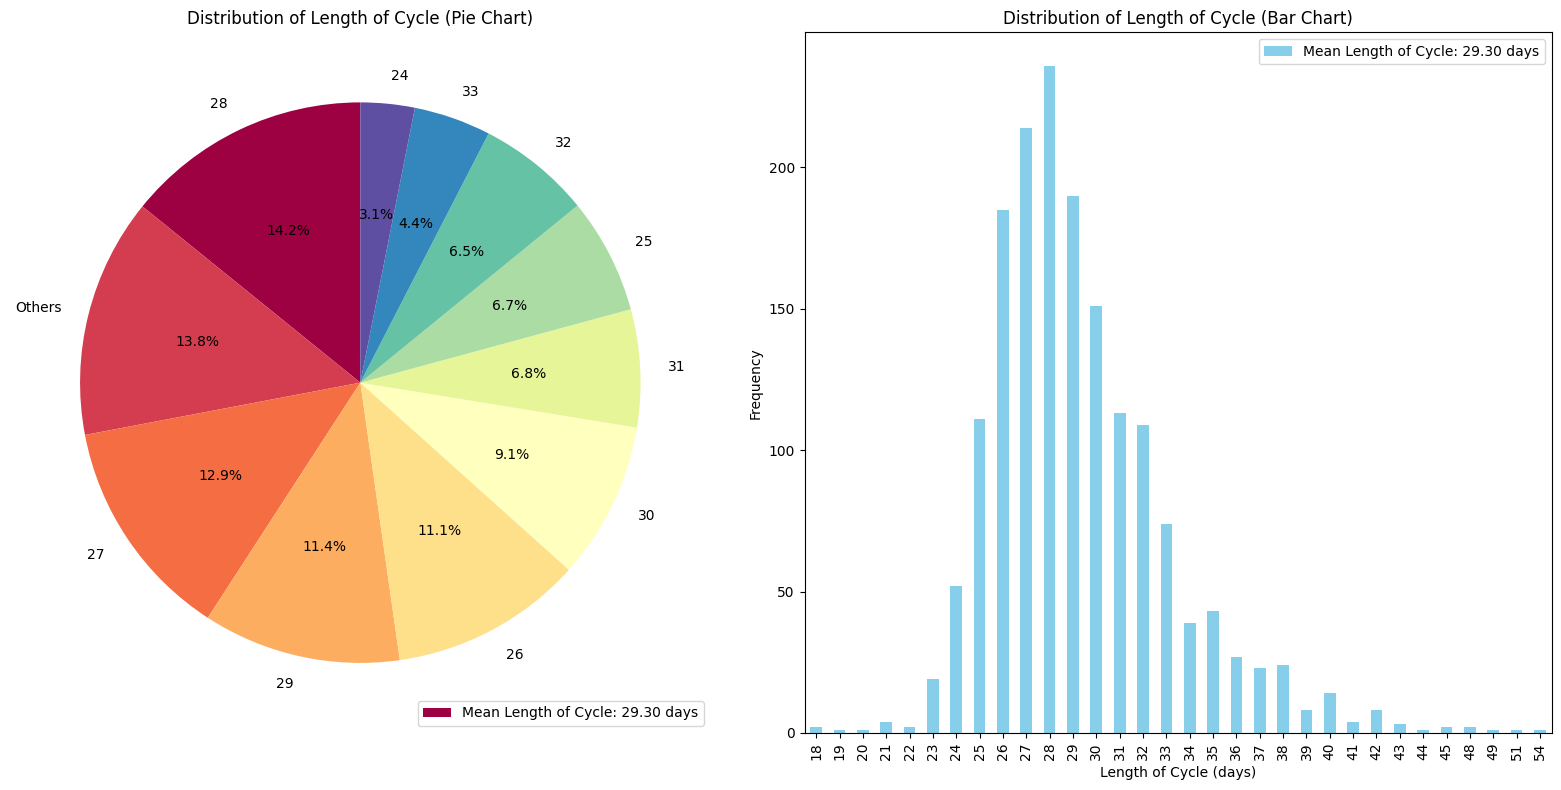

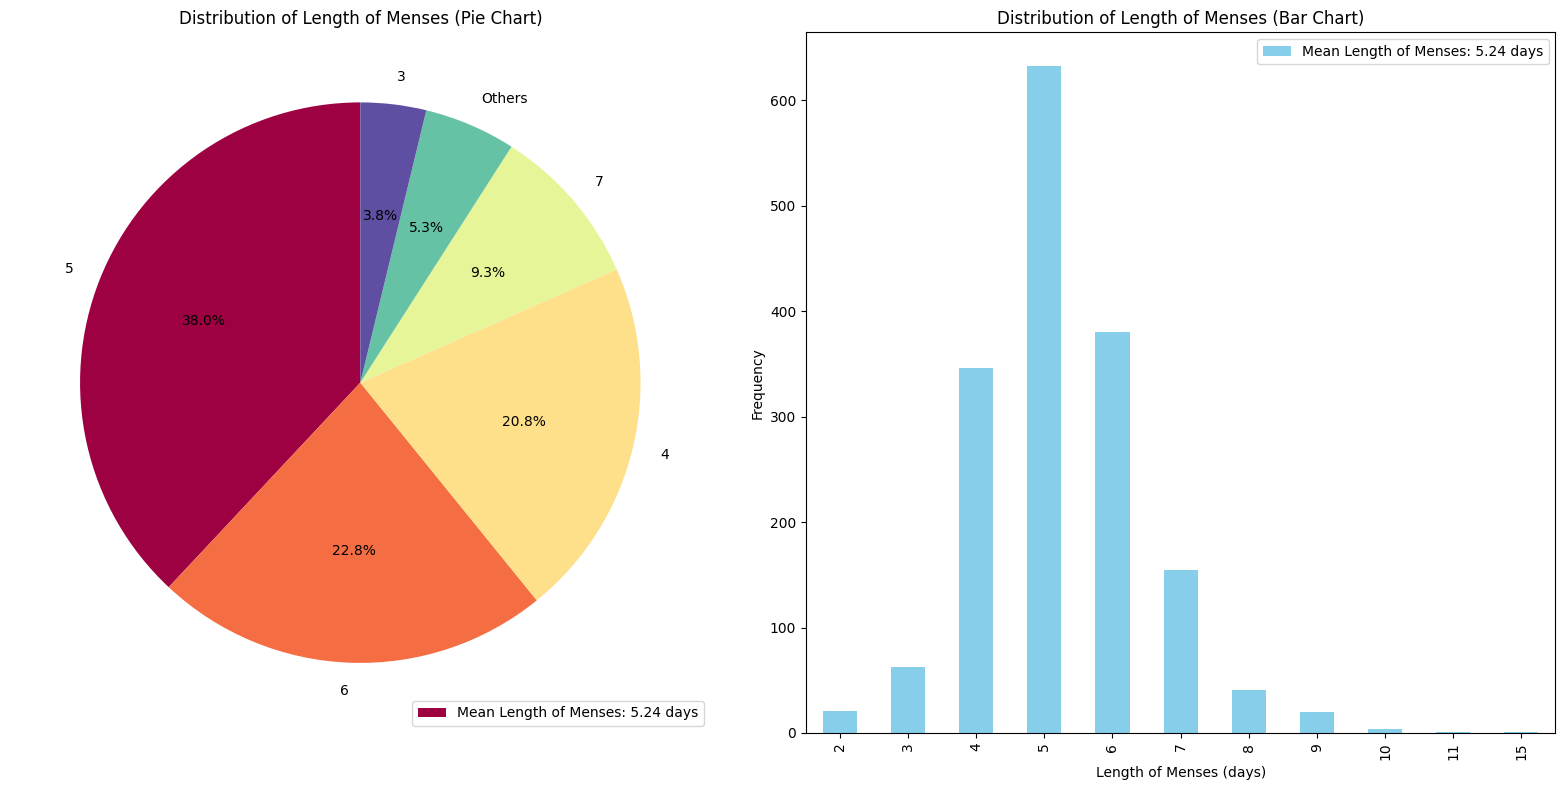

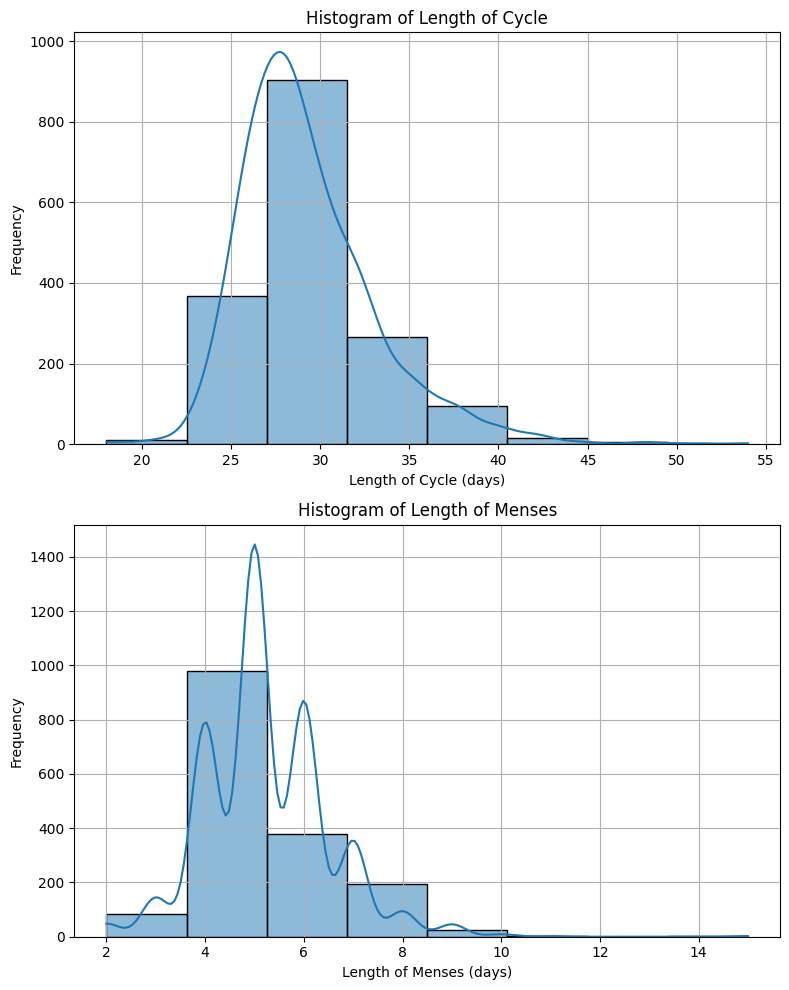

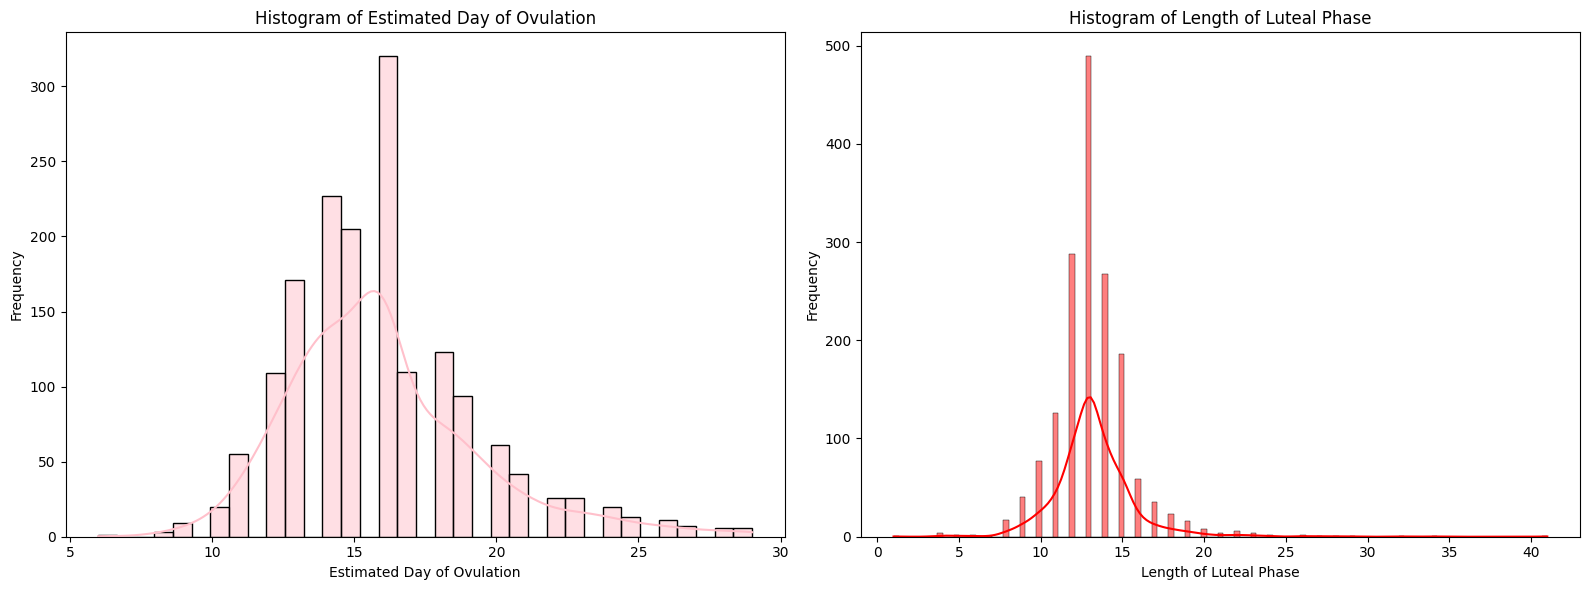

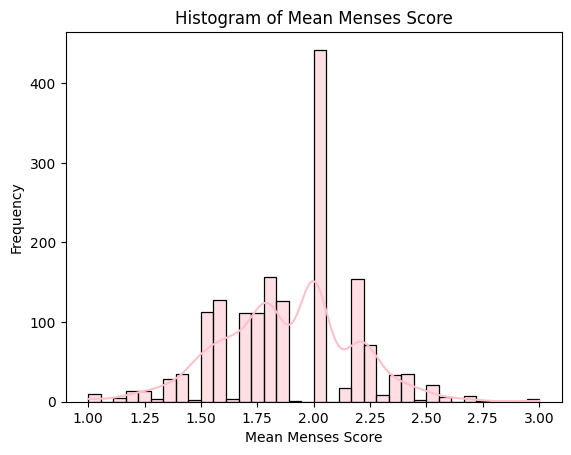

Index(['LengthofCycle', 'EstimatedDayofOvulation', 'LengthofLutealPhase',
       'LengthofMenses', 'MeanMensesScore', 'Cycle_Grouped', 'Menses_Grouped'],
      dtype='object')
Index(['LengthofCycle', 'EstimatedDayofOvulation', 'LengthofLutealPhase',
       'LengthofMenses', 'MeanMensesScore'],
      dtype='object')


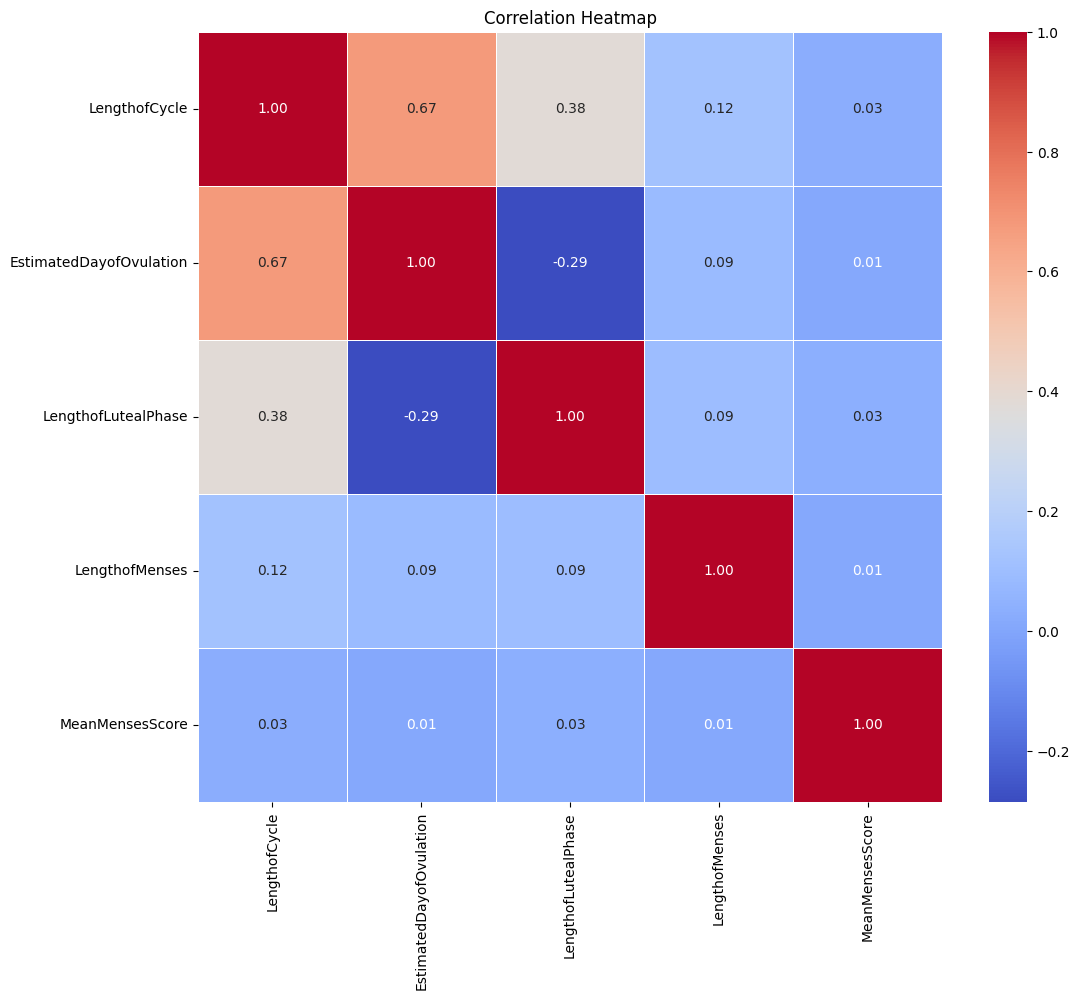

   LengthofCycle  EstimatedDayofOvulation  LengthofLutealPhase  \
0             29                       17                   12   
1             27                       15                   12   
2             29                       15                   14   
3             27                       15                   12   
4             28                       16                   12   

   LengthofMenses  MeanMensesScore               current_date  \
0               2              2.0 2025-01-29 22:06:57.163187   
1               2              2.0 2025-01-29 22:06:57.163187   
2               2              2.0 2025-01-29 22:06:57.163187   
3               2              2.4 2025-01-29 22:06:57.163187   
4               2              2.2 2025-01-29 22:06:57.163187   

      last_period_start_date  cycle_day  
0 2025-01-23 22:06:57.163187          6  
1 2025-01-10 22:06:57.163187         19  
2 2025-01-01 22:06:57.163187         28  
3 2025-01-15 22:06:57.163187         14  
4 

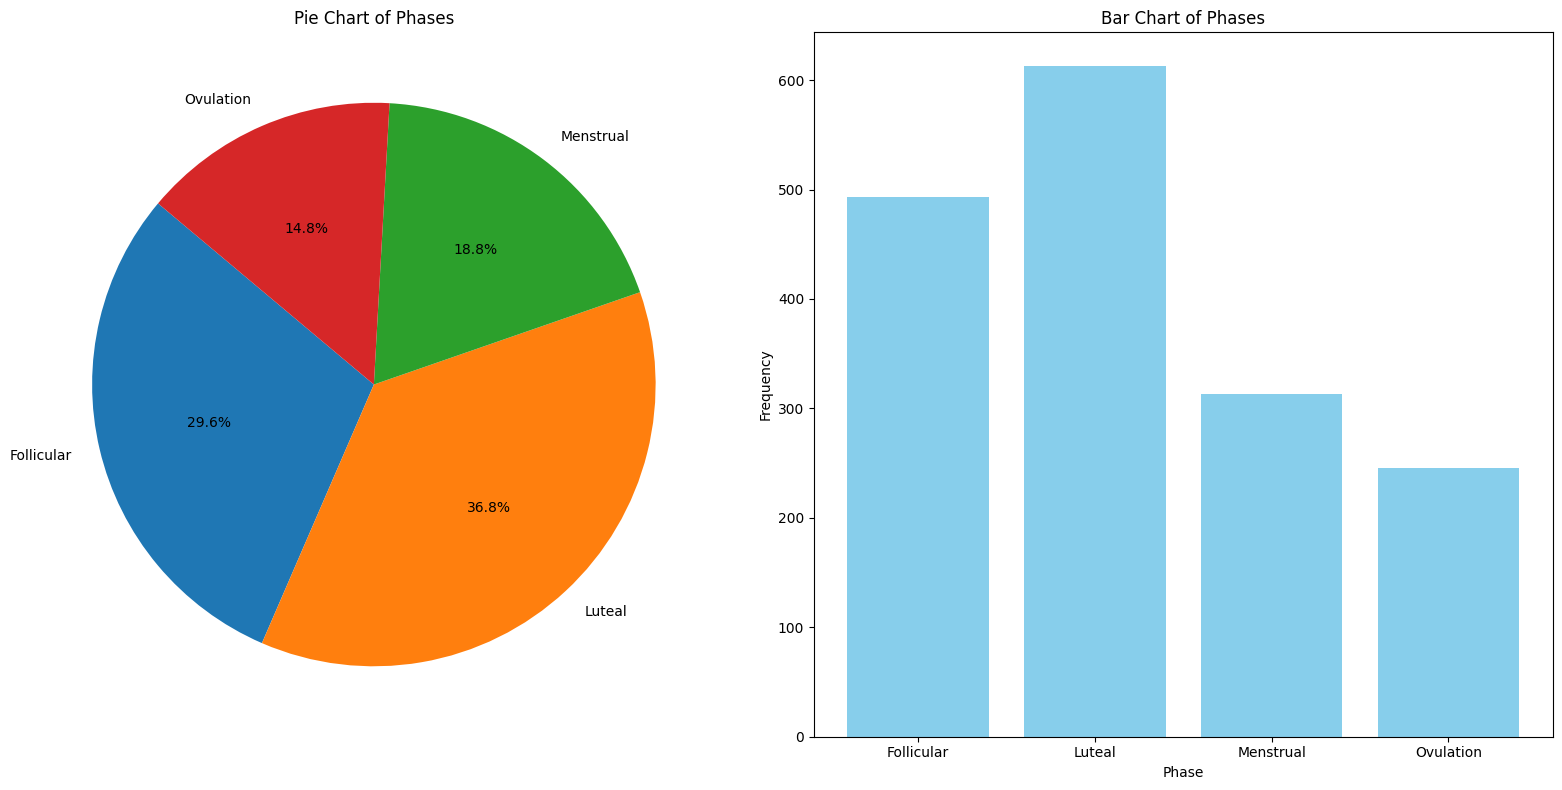

{'Follicular': np.int64(0), 'Luteal': np.int64(1), 'Menstrual': np.int64(2), 'Ovulation': np.int64(3)}
Index(['LengthofCycle', 'EstimatedDayofOvulation', 'LengthofLutealPhase',
       'LengthofMenses', 'MeanMensesScore', 'current_date',
       'last_period_start_date', 'cycle_day', 'phase', 'phase_encoded'],
      dtype='object')


In [1]:
%run preprocessing_3.ipynb

In [2]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from datetime import datetime, timedelta

y = df["phase_encoded"]

x = df.drop(
    [
        "phase",
        "phase_encoded",
        "current_date",
        "last_period_start_date",
        "LengthofLutealPhase",
        "EstimatedDayofOvulation",
    ],
    axis=1,
)

y = y[x.index]

In [3]:
print(x)

      LengthofCycle  LengthofMenses  MeanMensesScore  cycle_day
0                29               2         2.000000          6
1                27               2         2.000000         19
2                29               2         2.000000         28
3                27               2         2.400000         14
4                28               2         2.200000         10
...             ...             ...              ...        ...
1660             29              15         1.875000          7
1661             28               5         1.833333         18
1662             28               5         1.800000         17
1663             40               5         2.000000          0
1664             24               5         1.879427         13

[1665 rows x 4 columns]


In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=10
)

In [5]:
model_xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")
model_xgb.fit(x_train, y_train)

y_pred_xgb = model_xgb.predict(x_test)

report_xgb = classification_report(
    y_test, y_pred_xgb, target_names=label_encoder.classes_
)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Classification Report:\n", report_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb}")

XGBoost Classification Report:
               precision    recall  f1-score   support

  Follicular       0.99      0.99      0.99       104
      Luteal       0.99      0.97      0.98       116
   Menstrual       1.00      1.00      1.00        66
   Ovulation       0.92      0.98      0.95        47

    accuracy                           0.98       333
   macro avg       0.98      0.98      0.98       333
weighted avg       0.98      0.98      0.98       333

XGBoost Accuracy: 0.9819819819819819


In [6]:
from sklearn.metrics import log_loss

# Predict probabilities on the test set
y_pred_prob = model_xgb.predict_proba(x_test)

# Compute the multiclass log loss (mlogloss)
mlogloss_value = log_loss(y_test, y_pred_prob)

# Print the log loss value
print(f"Multiclass Log Loss (mlogloss): {mlogloss_value:.4f}")

Multiclass Log Loss (mlogloss): 0.0624


In [7]:
# check for overfitting
train_accuracy = accuracy_score(y_train, model_xgb.predict(x_train))
test_accuracy = accuracy_score(y_test, model_xgb.predict(x_test))
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 1.0
Test Accuracy: 0.9819819819819819


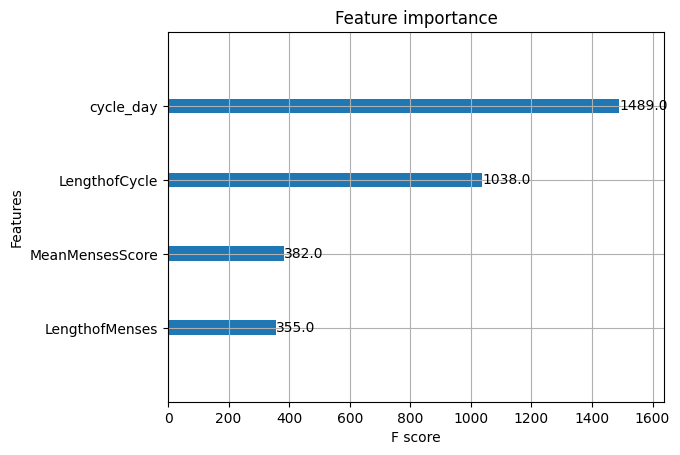

           Feature  Importance
3        cycle_day    0.631706
0    LengthofCycle    0.233182
1   LengthofMenses    0.112186
2  MeanMensesScore    0.022926


In [8]:
from xgboost import plot_importance

# Plot feature importance
plot_importance(model_xgb)
plt.show()

# Get feature importances
importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({"Feature": x_train.columns, "Importance": importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print(importance_df)

In [9]:
# SMOTE METHOD
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=41)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

model_xgb.fit(x_train_smote, y_train_smote)

y_pred_xgb = model_xgb.predict(x_test)

report_xgb = classification_report(
    y_test, y_pred_xgb, target_names=label_encoder.classes_
)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Classification Report after SMOTE:\n", report_xgb)
print(f"XGBoost Accuracy after SMOTE: {accuracy_xgb}")

XGBoost Classification Report after SMOTE:
               precision    recall  f1-score   support

  Follicular       0.99      0.97      0.98       104
      Luteal       0.99      0.96      0.97       116
   Menstrual       0.99      1.00      0.99        66
   Ovulation       0.88      0.98      0.93        47

    accuracy                           0.97       333
   macro avg       0.96      0.98      0.97       333
weighted avg       0.97      0.97      0.97       333

XGBoost Accuracy after SMOTE: 0.972972972972973


In [10]:
# FINDING HYPERTUNING PARAMETERS
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "learning_rate": [0.01, 0.1, 1],
}
grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5)
grid_search.fit(x_train, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200}


In [11]:
best_params = {"learning_rate": 0.1, "max_depth": 10, "n_estimators": 200}
final_model = XGBClassifier(**best_params, eval_metric="mlogloss")
final_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
# y_pred_final = final_model.predict(x_test)
# report_final = classification_report(
#     y_test, y_pred_final, target_names=label_encoder.classes_
# )
# accuracy_final = accuracy_score(y_test, y_pred_final)

# print("Final XGBoost Classification Report:\n", report_final)

# train_accuracy = accuracy_score(y_train, final_model.predict(x_train))
# test_accuracy = accuracy_score(y_test, final_model.predict(x_test))
# print(f"Training Accuracy: {train_accuracy}")
# print(f"Test Accuracy: {test_accuracy}")

grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5)
grid_search.fit(x_train_smote, y_train_smote)

# Step 3: Use the best hyperparameters found by GridSearchCV
best_params = grid_search.best_params_
final_model = XGBClassifier(**best_params, eval_metric="mlogloss")

# Step 4: Train the XGBoost model with SMOTE-applied data and best hyperparameters
final_model.fit(x_train_smote, y_train_smote)

# Step 5: Make predictions and evaluate the model on test data
y_pred_final = final_model.predict(x_test)

# Step 6: Print classification report and accuracy for the final model
report_final = classification_report(y_test, y_pred_final, target_names=label_encoder.classes_)
accuracy_final = accuracy_score(y_test, y_pred_final)
print("Final XGBoost Classification Report after SMOTE and Hyperparameter Tuning:\n", report_final)
print(f"Final XGBoost Test Accuracy: {accuracy_final}")


Final XGBoost Classification Report after SMOTE and Hyperparameter Tuning:
               precision    recall  f1-score   support

  Follicular       1.00      0.99      0.99        98
      Luteal       1.00      0.99      1.00       123
   Menstrual       1.00      1.00      1.00        63
   Ovulation       0.96      1.00      0.98        49

    accuracy                           0.99       333
   macro avg       0.99      1.00      0.99       333
weighted avg       0.99      0.99      0.99       333

Final XGBoost Test Accuracy: 0.993993993993994


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Sample data
# x, y = your feature set and target variable

# Define the best hyperparameters obtained from the previous tuning process
best_params = {"learning_rate": 0.1, "max_depth": 10, "n_estimators": 200}

# Initialize the XGBoost model with the best hyperparameters
model_xgb = XGBClassifier(**best_params, eval_metric="mlogloss")

# Set up cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics
accuracies = []
precision_sum = {}
recall_sum = {}
f1_sum = {}

# Initialize sums for each class
for label in label_encoder.classes_:
    precision_sum[label] = 0
    recall_sum[label] = 0
    f1_sum[label] = 0

# Start cross-validation loop
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to the training set
    smote = SMOTE(random_state=42)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

    # Train the model on resampled data
    model_xgb.fit(x_train_resampled, y_train_resampled)

    # Make predictions on the test set
    y_pred = model_xgb.predict(x_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Get classification report as a dictionary
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

    # Accumulate metrics for each class
    for label in label_encoder.classes_:
        precision_sum[label] += report[label]['precision']
        recall_sum[label] += report[label]['recall']
        f1_sum[label] += report[label]['f1-score']

# Calculate average metrics
average_accuracy = sum(accuracies) / len(accuracies)
average_report = {}

for label in label_encoder.classes_:
    average_report[label] = {
        'precision': precision_sum[label] / skf.n_splits,
        'recall': recall_sum[label] / skf.n_splits,
        'f1-score': f1_sum[label] / skf.n_splits,
        'support': np.sum(y == label) / skf.n_splits  # Average support
    }

# Print average accuracy
print(f"Average Accuracy: {average_accuracy:.4f}")

# Create a DataFrame for the average classification report
average_report_df = pd.DataFrame(average_report).T

# Print the average classification report as a table
print("\nAverage Classification Report:")
print(average_report_df)


Average Accuracy: 0.9826

Average Classification Report:
            precision    recall  f1-score  support
Follicular   0.982035  0.985817  0.983857      0.0
Luteal       0.987029  0.988565  0.987767      0.0
Menstrual    0.993649  0.993548  0.993573      0.0
Ovulation    0.960007  0.947020  0.952830      0.0


In [14]:
print(x.columns)

Index(['LengthofCycle', 'LengthofMenses', 'MeanMensesScore', 'cycle_day'], dtype='object')


In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# Sample data
# x, y = your feature set and target variable

# Initialize the individual models
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)

# Voting Classifier (Hard Voting)
voting_clf = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='hard')

# Initialize KFold Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics
accuracies_voting = []

# Start Cross-Validation Loop
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to the training set
    smote = SMOTE(random_state=42)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

    # Train Voting Classifier on SMOTE-applied data
    voting_clf.fit(x_train_resampled, y_train_resampled)
    y_pred_voting = voting_clf.predict(x_test)

    # Initial Accuracy for this fold
    accuracy_voting = accuracy_score(y_test, y_pred_voting)
    accuracies_voting.append(accuracy_voting)

    # Classification report for Voting Classifier
    print(f"Classification Report for Voting Classifier on this fold:\n", classification_report(y_test, y_pred_voting))

    # Step 1: Identify mistakes (Incorrect predictions)
    misclassified_indices = np.where(y_pred_voting != y_test)[0]

    # Step 2: Collect and resample mistakes
    x_train_mistakes = x_test.iloc[misclassified_indices]
    y_train_mistakes = y_test.iloc[misclassified_indices]

    # Step 3: Add misclassified data to the training set
    x_train_augmented = pd.concat([x_train_resampled, x_train_mistakes])
    y_train_augmented = pd.concat([y_train_resampled, y_train_mistakes])

    # Step 4: Re-train the model (focusing on those mistakes)
    print("Retraining on mistakes...")
    voting_clf.fit(x_train_augmented, y_train_augmented)

    # Step 5: Make predictions and evaluate on the test set again
    y_pred_voting_updated = voting_clf.predict(x_test)

    # New accuracy and classification report after learning from mistakes
    accuracy_voting_updated = accuracy_score(y_test, y_pred_voting_updated)
    print(f"Updated Classification Report after retraining:\n", classification_report(y_test, y_pred_voting_updated))

# Calculate and print average accuracy across all folds
average_accuracy_voting = np.mean(accuracies_voting)
print(f"\nAverage Accuracy (Voting Classifier, learning from mistakes): {average_accuracy_voting:.4f}")

Classification Report for Voting Classifier on this fold:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        99
           1       1.00      1.00      1.00       123
           2       1.00      0.95      0.98        62
           3       1.00      0.94      0.97        49

    accuracy                           0.98       333
   macro avg       0.99      0.97      0.98       333
weighted avg       0.98      0.98      0.98       333

Retraining on mistakes...
Updated Classification Report after retraining:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        99
           1       1.00      1.00      1.00       123
           2       1.00      0.98      0.99        62
           3       0.98      1.00      0.99        49

    accuracy                           0.99       333
   macro avg       0.99      0.99      0.99       333
weighted avg       0.99      0.99      0.99       3

In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Initialize the individual models
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)

# Stacking Classifier (Stack multiple models)
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

# KFold Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics
accuracies_stacking = []
precision_sum = {}
recall_sum = {}
f1_sum = {}

# Initialize sums for each class
for label in label_encoder.classes_:
    precision_sum[label] = 0
    recall_sum[label] = 0
    f1_sum[label] = 0

# Start Cross-Validation Loop
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to the training set
    smote = SMOTE(random_state=42)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

    # Train the stacking classifier on resampled data
    stacking_clf.fit(x_train_resampled, y_train_resampled)

    # Make predictions
    y_pred_stacking = stacking_clf.predict(x_test)

    # Calculate and store accuracy
    accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
    accuracies_stacking.append(accuracy_stacking)

    # Classification report for this fold
    report = classification_report(y_test, y_pred_stacking, target_names=label_encoder.classes_, output_dict=True)

    # Accumulate metrics for each class
    for label in label_encoder.classes_:
        precision_sum[label] += report[label]['precision']
        recall_sum[label] += report[label]['recall']
        f1_sum[label] += report[label]['f1-score']

# Calculate the average metrics over all folds
average_accuracy_stacking = np.mean(accuracies_stacking)
average_report = {}

for label in label_encoder.classes_:
    average_report[label] = {
        'precision': precision_sum[label] / skf.n_splits,
        'recall': recall_sum[label] / skf.n_splits,
        'f1-score': f1_sum[label] / skf.n_splits,
        'support': np.sum(y == label) / skf.n_splits  # Average support
    }

# Print the average accuracy
print(f"\nAverage Accuracy (Stacking Classifier): {average_accuracy_stacking:.4f}")

# Create a DataFrame for the average classification report
average_report_df = pd.DataFrame(average_report).T

# Print the average classification report as a table
print("\nAverage Classification Report (Stacking Classifier):")
print(average_report_df)


Average Accuracy (Stacking Classifier): 0.9832

Average Classification Report (Stacking Classifier):
            precision    recall  f1-score  support
Follicular   0.976449  0.989858  0.982970      0.0
Luteal       0.988694  0.991830  0.990230      0.0
Menstrual    0.993700  0.987148  0.990267      0.0
Ovulation    0.971909  0.943020  0.956626      0.0


In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Assume x and y are already defined
# Example
# x = pd.DataFrame(...)  # Your feature dataframe
# y = pd.Series(...)  # Your target

# Encode labels if necessary
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Only apply if y isn't already numerical

# Initialize the base classifiers with hyperparameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
svc_model = SVC(probability=True, random_state=42)  # Adding SVC with probability estimates

# Voting Classifier (Soft voting uses probability estimates)
voting_clf = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('lr', lr_model), ('svc', svc_model)],
    voting='soft'  # Using predicted probabilities
)

# KFold Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics
accuracies_voting = []
precision_sum = {}
recall_sum = {}
f1_sum = {}

# Initialize sums for each class
for label in label_encoder.classes_:
    precision_sum[label] = 0
    recall_sum[label] = 0
    f1_sum[label] = 0

# Start Cross-Validation Loop
for train_index, test_index in skf.split(x, y_encoded):  # Use encoded y for splitting
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Apply SMOTE to the training set
    smote = SMOTE(random_state=42)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

    # Train the Voting Classifier on the resampled data
    voting_clf.fit(x_train_resampled, y_train_resampled)

    # Make predictions
    y_pred_voting = voting_clf.predict(x_test)

    # Calculate and store accuracy
    accuracy_voting = accuracy_score(y_test, y_pred_voting)
    accuracies_voting.append(accuracy_voting)

    # Classification report for this fold
    report = classification_report(y_test, y_pred_voting, target_names=label_encoder.classes_, output_dict=True)

    # Accumulate metrics for each class
    for label in label_encoder.classes_:
        precision_sum[label] += report[label]['precision']
        recall_sum[label] += report[label]['recall']
        f1_sum[label] += report[label]['f1-score']

# Calculate the average metrics over all folds
average_accuracy_voting = np.mean(accuracies_voting)
average_report = {}

for label in label_encoder.classes_:
    average_report[label] = {
        'precision': precision_sum[label] / skf.n_splits,
        'recall': recall_sum[label] / skf.n_splits,
        'f1-score': f1_sum[label] / skf.n_splits,
        'support': np.sum(y == label) / skf.n_splits  # Average support
    }

# Print the average accuracy
print(f"\nAverage Accuracy (Voting Classifier - soft voting): {average_accuracy_voting:.4f}")

# Create a DataFrame for the average classification report
average_report_df = pd.DataFrame(average_report).T

# Print the average classification report as a table
print("\nAverage Classification Report (Voting Classifier - soft voting):")
print(average_report_df)


c:\Users\anagh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Average Accuracy (Voting Classifier - soft voting): 0.9958

Average Classification Report (Voting Classifier - soft voting):
   precision    recall  f1-score  support
0   0.998000  0.991899  0.994913     98.6
1   1.000000  0.996735  0.998361    122.6
2   0.993700  0.996774  0.995199     62.6
3   0.984235  1.000000  0.992000     49.2


c:\Users\anagh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
import joblib

# Save the voting classifier (including the training process)
joblib.dump(voting_clf, 'voting_classifier_model.joblib')

['voting_classifier_model.joblib']

In [53]:
from sklearn.metrics import log_loss

# Predict probabilities on the test set using the voting classifier
y_pred_prob_voting = voting_clf.predict_proba(x_test)

# Compute the multiclass log loss (mlogloss)
mlogloss_value_voting = log_loss(y_test, y_pred_prob_voting)

# Print the log loss value
print(f"Multiclass Log Loss (mlogloss) for Voting Model: {mlogloss_value_voting:.4f}")


Multiclass Log Loss (mlogloss) for Voting Model: 0.0516


In [15]:
import time

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Updated dietary recommendations based on phases
menstrual_tips = {
    "menstrual": {
        "veg": {
            "recommended": ["Spinach", "Broccoli", "Sweet Potatoes", "Beetroot"],
            "foods_to_avoid": [
                "Caffeine",
                "Processed foods",
                "Sugary snacks",
                "Salty foods",
            ],
        },
        "non_veg": {
            "recommended": ["Chicken", "Salmon", "Eggs"],
            "foods_to_avoid": [
                "Caffeine",
                "Processed foods",
                "Sugary snacks",
                "Salty foods",
            ],
        },
        "vegan": {
            "recommended": ["Kale", "Tofu", "Quinoa", "Avocado"],
            "foods_to_avoid": [
                "Caffeine",
                "Processed foods",
                "Sugary snacks",
                "Salty foods",
            ],
        },
        "hydration": "Stay hydrated by drinking plenty of water and herbal teas like ginger or chamomile to ease cramps.",
    },
    "follicular": {
        "veg": {
            "recommended": ["Lentils", "Zucchini", "Bell Peppers", "Pumpkin Seeds"],
            "foods_to_avoid": ["Refined carbs", "Excessive sugar", "Heavy fats"],
        },
        "non_veg": {
            "recommended": ["Turkey", "Tuna", "Lean Beef"],
            "foods_to_avoid": ["Refined carbs", "Excessive sugar", "Heavy fats"],
        },
        "vegan": {
            "recommended": ["Chia Seeds", "Oats", "Flaxseeds", "Almonds"],
            "foods_to_avoid": ["Refined carbs", "Excessive sugar", "Heavy fats"],
        },
        "hydration": "Focus on hydrating with electrolyte-rich drinks such as coconut water and green juices.",
    },
    "ovulation": {
        "veg": {
            "recommended": ["Asparagus", "Brussels Sprouts", "Peas"],
            "foods_to_avoid": ["Processed foods", "Fried foods", "Caffeine"],
        },
        "non_veg": {
            "recommended": ["Chicken", "Shrimp", "Eggs"],
            "foods_to_avoid": ["Processed foods", "Fried foods", "Caffeine"],
        },
        "vegan": {
            "recommended": ["Hemp Seeds", "Tempeh", "Chickpeas"],
            "foods_to_avoid": ["Processed foods", "Fried foods", "Caffeine"],
        },
        "hydration": "Drink plenty of water and consider adding fruit-infused water to boost hydration during this phase.",
    },
    "luteal": {
        "veg": {
            "recommended": ["Carrots", "Sweet Potatoes", "Cauliflower"],
            "foods_to_avoid": ["Excess salt", "Alcohol", "Caffeine", "Greasy foods"],
        },
        "non_veg": {
            "recommended": ["Lamb", "Salmon", "Turkey"],
            "foods_to_avoid": ["Excess salt", "Alcohol", "Caffeine", "Greasy foods"],
        },
        "vegan": {
            "recommended": ["Brown Rice", "Walnuts", "Chia Seeds"],
            "foods_to_avoid": ["Excess salt", "Alcohol", "Caffeine", "Greasy foods"],
        },
        "hydration": "Herbal teas like peppermint or chamomile can help reduce bloating. Continue with adequate water intake.",
    },
}

phase_mapping = {0: "follicular", 1: "luteal", 2: "menstrual", 3: "ovulation"}


def get_tips(phase, diet):
    """Get dietary tips based on the phase and diet type."""
    if phase in menstrual_tips and diet in menstrual_tips[phase]:
        return {
            "recommendations": menstrual_tips[phase][diet]["recommended"],
            "hydration": menstrual_tips[phase]["hydration"],
            "foods_to_avoid": menstrual_tips[phase][diet]["foods_to_avoid"],
        }
    return None


def plot_phase_visualization(predicted_df, days_since_last_period):
    """Visualize the predicted phases across the menstrual cycle."""
    plt.figure(figsize=(12, 6))
    plt.plot(
        predicted_df["Day"],
        predicted_df["Predicted Phase"],
        marker="o",
        linestyle="-",
        markersize=8,
        color="b",
    )
    plt.axvline(
        x=days_since_last_period, color="r", linestyle="--", label="Today"
    )  # Highlight current day
    plt.title("Predicted Phases Across the Menstrual Cycle")
    plt.xlabel("Day of Cycle")
    plt.ylabel("Predicted Phase")
    plt.xticks(
        np.arange(1, len(predicted_df) + 1, 1)
    )  # Set x-ticks from 1 to cycle_length
    plt.grid(True)
    plt.legend()
    plt.show()


def predict_and_visualize_phases(
    cycle_length, menses_length, mean_menses_score, last_period_start_date, model
):
    """Predict menstrual phases and visualize the predictions."""

    # Create data for each day in the cycle
    all_days = pd.DataFrame(
        {
            "LengthofCycle": [cycle_length] * cycle_length,
            "LengthofMenses": [menses_length] * cycle_length,
            "MeanMensesScore": [mean_menses_score] * cycle_length,
            "cycle_day": np.arange(cycle_length),  # Days from 0 to cycle_length - 1
        }
    )

    predicted_phases = model.predict(all_days)

    predicted_df = pd.DataFrame(
        {
            "Day": np.arange(1, cycle_length + 1),
            "Predicted Phase": [phase_mapping[pred] for pred in predicted_phases],
        }
    )

    current_date = pd.Timestamp(datetime.today())
    days_since_last_period = (
        current_date - pd.Timestamp(last_period_start_date)
    ).days % cycle_length

    current_day_data = pd.DataFrame(
        {
            "LengthofCycle": [cycle_length],
            "LengthofMenses": [menses_length],
            "MeanMensesScore": [mean_menses_score],
            "cycle_day": [
                days_since_last_period
            ],  # Keep this as is for current day data
        }
    )

    predicted_phase_today = model.predict(current_day_data)[0]

    predicted_phase_today_name = phase_mapping[predicted_phase_today]

    plot_phase_visualization(
        predicted_df, days_since_last_period
    )  # Pass the correct day

    return predicted_df, predicted_phase_today_name


def get_diet_from_choice(choice):
    if choice == 1:
        return "non_veg"
    elif choice == 2:
        return "veg"
    elif choice == 3:
        return "vegan"
    return None


def combined_prediction_and_recommendation(
    cycle_length, menses_length, mean_menses_score, last_period_start_date, model_xgb
):
    """Combine prediction and dietary recommendations."""

    predicted_df, predicted_phase_today = predict_and_visualize_phases(
        cycle_length,
        menses_length,
        mean_menses_score,
        last_period_start_date,
        model_xgb,
    )

    # Get diet choice from user
    print("\nToday's predicted phase is:", predicted_phase_today)
    # print("\nChoose your diet:")
    # print("1. Non-veg")
    # print("2. Veg")
    # print("3. Vegan")

    try:
        diet_choice = int(input("Enter your choice (1/2/3): "))
        diet = get_diet_from_choice(diet_choice)

        if diet:
            tips = get_tips(predicted_phase_today.lower(), diet)

            if tips:
                recommendations = tips["recommendations"]
                hydration = tips["hydration"]
                foods_to_avoid = tips["foods_to_avoid"]

                print(
                    f"\nRecommended foods for the {predicted_phase_today} phase (Diet: {diet}):"
                )
                for food in recommendations:
                    print(f"- {food}")

                print(f"\nHydration tip for the {predicted_phase_today} phase:")
                print(hydration)

                print(f"\nFoods to avoid during the {predicted_phase_today} phase:")
                for food in foods_to_avoid:
                    print(f"- {food}")
            else:
                print("Invalid diet choice for this phase. Please try again.")
        else:
            print(
                "Invalid choice! Please select 1 for Non-veg, 2 for Veg, or 3 for Vegan."
            )
    except ValueError:
        print("Invalid input. Please enter a valid number (1/2/3).")

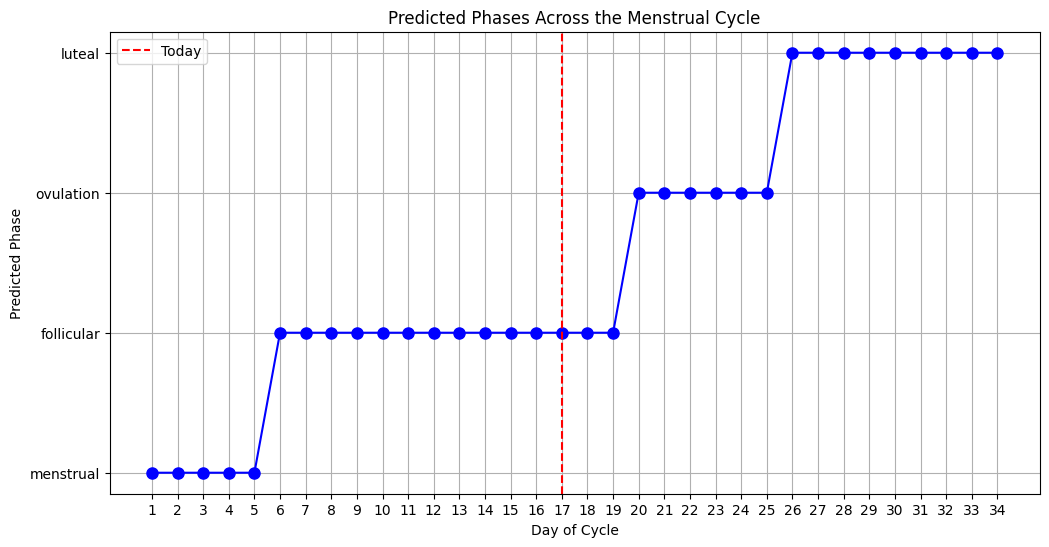


Today's predicted phase is: follicular

Recommended foods for the follicular phase (Diet: veg):
- Lentils
- Zucchini
- Bell Peppers
- Pumpkin Seeds

Hydration tip for the follicular phase:
Focus on hydrating with electrolyte-rich drinks such as coconut water and green juices.

Foods to avoid during the follicular phase:
- Refined carbs
- Excessive sugar
- Heavy fats


In [17]:
cycle_length = 34
menses_length = 5
mean_menses_score = 2  # ranges from 1-3
last_period_start_date = datetime.today() - timedelta(days=17)
model = final_model

combined_prediction_and_recommendation(
    cycle_length, menses_length, mean_menses_score, last_period_start_date, model
)

In [18]:
current_date = pd.Timestamp(datetime.today())
days_since_last_period = (
    current_date - pd.Timestamp(last_period_start_date)
).days % cycle_length

current_day_data = pd.DataFrame(
    {
        "LengthofCycle": [cycle_length],
        "LengthofMenses": [menses_length],
        "MeanMensesScore": [mean_menses_score],
        "cycle_day": [days_since_last_period],  # Keep this as is for current day data
    }
)

# Measure latency
start_time = time.time()

predicted_phase_today = model_xgb.predict(current_day_data)[0]

end_time = time.time()

latency = end_time - start_time
print(f"Prediction took {latency:.4f} seconds")

Prediction took 0.0090 seconds


In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model on the training data
rf.fit(x_train, y_train)

# Measure latency
start_time = time.time()
# Predict on the test set
y_pred = rf.predict(x_test)

end_time = time.time()

latency = end_time - start_time

# Evaluate the model
print(classification_report(y_test, y_pred))

print(f"Prediction took {latency:.4f} seconds")

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        98
           1       0.98      0.98      0.98       123
           2       1.00      1.00      1.00        63
           3       0.92      0.92      0.92        49

    accuracy                           0.98       333
   macro avg       0.97      0.97      0.97       333
weighted avg       0.98      0.98      0.98       333

Prediction took 0.0211 seconds


In [20]:
from sklearn.svm import SVC

# Create a kernel SVM model
svm_model = SVC(kernel="rbf", random_state=42)

# Train the model on the training data
svm_model.fit(x_train, y_train)

# Measure latency
start_time = time.time()
# Predict on the test set
y_pred = svm_model.predict(x_test)

end_time = time.time()

latency = end_time - start_time

# Evaluate the model
print(classification_report(y_test, y_pred))

print(f"Prediction took {latency:.4f} seconds")

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        98
           1       1.00      1.00      1.00       123
           2       0.95      1.00      0.98        63
           3       1.00      0.98      0.99        49

    accuracy                           0.99       333
   macro avg       0.99      0.99      0.99       333
weighted avg       0.99      0.99      0.99       333

Prediction took 0.0339 seconds


In [21]:
train_accuracy = accuracy_score(y_train, svm_model.predict(x_train))
test_accuracy = accuracy_score(y_test, svm_model.predict(x_test))
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9804804804804805
Test Accuracy: 0.987987987987988


In [22]:
def gui_predict_phases(
    cycle_length, menses_length, mean_menses_score, last_period_start_date, model
):
    """Predict menstrual phases and visualize the predictions."""

    # Create data for each day in the cycle
    all_days = pd.DataFrame(
        {
            "LengthofCycle": [cycle_length] * cycle_length,
            "LengthofMenses": [menses_length] * cycle_length,
            "MeanMensesScore": [mean_menses_score] * cycle_length,
            "cycle_day": np.arange(cycle_length),  # Days from 0 to cycle_length - 1
        }
    )

    predicted_phases = model.predict(all_days)

    predicted_df = pd.DataFrame(
        {
            "Day": np.arange(1, cycle_length + 1),
            "Predicted Phase": [phase_mapping[pred] for pred in predicted_phases],
        }
    )

    current_date = pd.Timestamp(datetime.today())
    days_since_last_period = (
        current_date - pd.Timestamp(last_period_start_date)
    ).days % cycle_length

    current_day_data = pd.DataFrame(
        {
            "LengthofCycle": [cycle_length],
            "LengthofMenses": [menses_length],
            "MeanMensesScore": [mean_menses_score],
            "cycle_day": [
                days_since_last_period
            ],  # Keep this as is for current day data
        }
    )

    predicted_phase_today = model.predict(current_day_data)[0]
    predicted_phase_today_name = phase_mapping[predicted_phase_today]

    return predicted_df, predicted_phase_today_name


def gui_get_diet_from_choice(choice):
    if choice == "Non-veg":
        return "non_veg"
    elif choice == "Veg":
        return "veg"
    elif choice == "Vegan":
        return "vegan"
    return None


phase_mapping = {0: "follicular", 1: "luteal", 2: "menstrual", 3: "ovulation"}

In [23]:
menstrual_tips = {
    "menstrual": {
        "veg": [
            {"name": "Spinach", "recipes": [{"title": "Spinach and Chickpea Stir-fry", "link": "https://cooking.nytimes.com/recipes/1012408-chickpeas-with-baby-spinach"}, {"title": "Spinach Smoothie", "link": "https://www.jessicagavin.com/spinach-smoothie/"}]},
            {"name": "Broccoli", "recipes": [{"title": "Broccoli Stir Fry Curry", "link": "https://www.indianhealthyrecipes.com/broccoli-curry-recipe-indian-broccoli-stir-fry/"}, {"title": "Chilli Garlic Broccoli", "link": "https://nadiashealthykitchen.com/smashed-chilli-garlic-broccoli/"}]},
            {"name": "Sweet Potatoes", "recipes": [{"title": "Baked Sweet Potato Fries", "link": "https://cookieandkate.com/baked-sweet-potato-fries/"}, {"title": "Sweet Potato Soup", "link": "https://www.loveandlemons.com/sweet-potato-soup/"}]},
            {"name": "Beetroot", "recipes": [{"title": "Beetroot and Quinoa Salad", "link": "https://cookieandkate.com/raw-beet-salad-with-carrot-quinoa-spinach/"}, {"title": "Roasted Beetroot", "link": "https://cookieandkate.com/perfect-roasted-beets/"}]}
        ],
        "non_veg": [
            {"name": "Chicken", "recipes": [{"title": "Grilled Lemon Herb Chicken", "link": "https://www.eatingwell.com/recipe/262867/grilled-lemon-herb-chicken/"}, {"title": "Chicken Stir Fry", "link": "https://natashaskitchen.com/chicken-stir-fry-recipe/"}]},
            {"name": "Salmon", "recipes": [{"title": "Baked Salmon with Dill and Lemon", "link": "https://www.inspiredtaste.net/149/moms-oven-poached-salmon/"}, {"title": "Honey Garlic Salmon", "link": "https://www.recipetineats.com/honey-garlic-salmon-5-ingredients-15-minutes/"}]},
            {"name": "Eggs", "recipes": [{"title": "Vegetable Omelette", "link": "https://www.allrecipes.com/recipe/14057/yummy-veggie-omelet/"}, {"title": "Boiled Eggs with Avocado Toast", "link": "https://www.inspiredtaste.net/37119/avocado-toast-with-egg/"}]}
        ],
        "vegan": [
            {"name": "Kale", "recipes": [{"title": "Kale and Avocado Smoothie", "link": "https://www.thelittleepicurean.com/avocado-kale-smoothie/"}, {"title": "Kale Chips", "link": "https://www.allrecipes.com/recipe/176957/baked-kale-chips/"}]},
            {"name": "Tofu", "recipes": [{"title": "Stir-fried Tofu with Vegetables", "link": "https://www.skinnytaste.com/tofu-stir-fry-with-vegetables-in-a-soy-sesame-sauce/"}, {"title": "Crispy Baked Tofu", "link": "https://cookieandkate.com/how-to-make-crispy-baked-tofu/"}]},
            {"name": "Quinoa", "recipes": [{"title": "Quinoa and Black Bean Bowl", "link": "https://www.eatingwell.com/recipe/260726/black-bean-quinoa-buddha-bowl/"}, {"title": "Quinoa Breakfast Porridge", "link": "https://foolproofliving.com/coconut-quinoa-porridge-berries-quinoa-crunch-topping/"}]},
            {"name": "Avocado", "recipes": [{"title": "Avocado Toast with Tomato", "link": "https://writtenbyvegan.com/blog/avocado-toast-with-grilled-tomatoes/"}, {"title": "Avocado Salad", "link": "https://www.cookingclassy.com/avocado-salad/"}]}
        ],
        "hydration": "Stay hydrated by drinking plenty of water and herbal teas like ginger or chamomile to ease cramps.",
        "foods_to_avoid": ["Caffeine", "Processed foods", "Sugary snacks", "Salty foods", "Red Meat"]
    },
    "follicular": {
        "veg": [
            {"name": "Lentils", "recipes": [{"title": "Lentil Soup", "link": "https://www.recipetineats.com/lentil-soup/"}, {"title": "Lentil Salad", "link": "https://www.twopeasandtheirpod.com/lentil-salad/"}]},
            {"name": "Zucchini", "recipes": [{"title": "Zucchini Noodles with Pesto", "link": "https://www.twopeasandtheirpod.com/zucchini-noodles-with-pesto/"}, {"title": "Stuffed Zucchini", "link": "https://www.loveandlemons.com/stuffed-zucchini-boats/"}]},
            {"name": "Bell Peppers", "recipes": [{"title": "Stuffed Bell Peppers", "link": "https://www.budgetbytes.com/stuffed-bell-peppers/"}, {"title": "Grilled Bell Peppers", "link": "https://jamjarkitchen.com/2021/06/21/easy-grilled-bell-peppers/"}]},
            {"name": "Pumpkin Seeds", "recipes": [{"title": "Roasted Pumpkin Seeds", "link": "https://www.inspiredtaste.net/35546/easy-roasted-pumpkin-seeds-recipe/"}, {"title": "Pumpkin Seed Pesto", "link": "https://www.thespruceeats.com/pumpkin-seed-pesto-recipe-101942"}]}
        ],
        "non_veg": [
            {"name": "Turkey", "recipes": [{"title": "Roast Turkey Breast", "link": "https://tastesbetterfromscratch.com/roasted-turkey-breast/"}, {"title": "Turkey Meatballs", "link": "https://www.culinaryhill.com/turkey-meatballs/"}]},
            {"name": "Tuna", "recipes": [{"title": "Tuna Salad", "link": "https://downshiftology.com/recipes/tuna-salad/"}, {"title": "Tuna Steak", "link": "https://www.recipetineats.com/tuna-steak/"}]},
            {"name": "Lean Beef", "recipes": [{"title": "Beef Stir Fry", "link": "https://www.bbcgoodfood.com/recipes/beef-stir-fry"}, {"title": "Lean Beef Chili", "link": "https://www.allrecipes.com/recipe/13006/lean-beef-chili/"}]}
        ],
        "vegan": [
            {"name": "Chia Seeds", "recipes": [{"title": "Chia Pudding", "link": "https://www.loveandlemons.com/chia-seed-pudding/"}, {"title": "Chia Seed Smoothie", "link": "https://www.jaroflemons.com/strawberry-banana-chia-seed-smoothie/"}]},
            {"name": "Oats", "recipes": [{"title": "Overnight Oats", "link": "https://www.loveandlemons.com/overnight-oats-recipe/"}, {"title": "Oatmeal Porridge", "link": "https://www.vegrecipesofindia.com/oats-porridge-recipe/"}]},
            {"name": "Flaxseeds", "recipes": [{"title": "Flaxseed Smoothie", "link": "https://www.allrecipes.com/recipe/161325/flax-seed-smoothie/"}, {"title": "Flaxseed Crackers", "link": "https://www.allrecipes.com/recipe/261801/flax-seed-crackers/"}]},
            {"name": "Almonds", "recipes": [{"title": "Roasted Almonds", "link": "https://www.heynutritionlady.com/oven-roasted-almonds/"}, {"title": "Almond Laddu", "link": "https://hebbarskitchen.com/badam-ladoo-recipe-almond-laddu/"}]}
        ],
        "hydration": "Focus on hydrating with electrolyte-rich drinks such as coconut water and green juices.",
        "foods_to_avoid": ["Refined carbs", "Excessive sugar", "Heavy fats"]
    },
    "ovulation": {
        "veg": [
            {"name": "Asparagus", "recipes": [{"title": "Roasted Asparagus", "link": "https://cookieandkate.com/perfect-roasted-asparagus-recipe/"}, {"title": "Asparagus Soup", "link": "https://www.loveandlemons.com/asparagus-soup/"}]},
            {"name": "Brussels Sprouts", "recipes": [{"title": "Roasted Brussels Sprouts", "link": "https://www.loveandlemons.com/roasted-brussels-sprouts/"}, {"title": "Brussels Sprouts Salad", "link": "https://www.loveandlemons.com/shaved-brussels-sprout-salad/"}]},
            {"name": "Peas", "recipes": [{"title": "Pea Risotto", "link": "https://www.bbcgoodfood.com/recipes/pea-risotto"}, {"title": "Pea Soup", "link": "https://www.eatingwell.com/recipe/249993/pea-soup/"}]}
        ],
        "non_veg": [
            {"name": "Chicken", "recipes": [{"title": "Grilled Chicken Skewers", "link": "https://www.gimmesomeoven.com/grilled-chicken-kabobs/"}, {"title": "Chicken Caesar Salad", "link": "https://damndelicious.net/2023/04/21/best-chicken-caesar-salad-with-homemade-croutons/"}]},
            {"name": "Shrimp", "recipes": [{"title": "Garlic Butter Shrimp", "link": "https://www.wellplated.com/garlic-butter-shrimp/"}, {"title": "Shrimp Stir Fry", "link": "https://healthyrecipesblogs.com/shrimp-stir-fry/"}]},
            {"name": "Eggs", "recipes": [{"title": "Poached Eggs on Toast", "link": "https://fortheloveofcooking.net/2014/09/poached-egg-on-toast.html"}, {"title": "Egg Curry", "link": "https://www.indianhealthyrecipes.com/punjabi-egg-curry-anda-curry-dhaba-style/"}]}
        ],
        "vegan": [
            {"name": "Hemp Seeds", "recipes": [{"title": "Hemp Seed Smoothie", "link": "https://simple-veganista.com/banana-mandarin-smoothie/"}, {"title": "Hemp Seed Energy Balls", "link": "https://mcdanielnutrition.com/recipe-no-bake-cocoa-hemp-seed-energy-bites/"}]},
            {"name": "Tempeh", "recipes": [{"title": "Tempeh Stir Fry", "link": "https://mcdanielnutrition.com/recipe-no-bake-cocoa-hemp-seed-energy-bites/"}, {"title": "Grilled Tempeh", "link": "https://thealmondeater.com/grilled-tempeh/"}]},
            {"name": "Chickpeas", "recipes": [{"title": "Chickpea Curry", "link": "https://www.indianhealthyrecipes.com/chickpea-curry/"}, {"title": "Roasted Chickpeas", "link": "https://www.loveandlemons.com/roasted-chickpeas/"}]}
        ],
        "hydration": "Drink plenty of water and consider adding fruit-infused water to boost hydration during this phase.",
        "foods_to_avoid": ["Processed foods", "Fried foods", "Caffeine"]
    },
    "luteal": {
         "veg": [
        {"name": "Carrots", "recipes": [{"title": "Honey Roasted Carrots", "link": "https://www.allrecipes.com/recipe/214079/honey-roasted-carrots/"}, {"title": "Carrot Soup", "link": "https://www.vegrecipesofindia.com/carrot-soup/"}]},
        {"name": "Sweet Potatoes", "recipes": [{"title": "Mashed Sweet Potatoes", "link": "https://www.allrecipes.com/recipe/21220/mashed-sweet-potatoes/"}, {"title": "Sweet Potato Casserole", "link": "https://www.allrecipes.com/recipe/21261/yummy-sweet-potato-casserole/"}]},
        {"name": "Spinach", "recipes": [{"title": "Creamed Spinach", "link": "https://www.onceuponachef.com/recipes/creamed-spinach.html"}, {"title": "Spinach and Mushroom Frittata", "link": "https://www.ricardocuisine.com/en/recipes/5849-mushroom-and-spinach-frittata"}]},
        {"name": "Broccoli", "recipes": [{"title": "Broccoli Stir Fry Curry", "link": "https://www.indianhealthyrecipes.com/broccoli-curry-recipe-indian-broccoli-stir-fry/"}, {"title": "Chilli Garlic Broccoli", "link": "https://nadiashealthykitchen.com/smashed-chilli-garlic-broccoli/"}]},
    ],
    "non_veg": [
        {"name": "Turkey", "recipes": [{"title": "Roast Turkey Breast", "link": "https://tastesbetterfromscratch.com/roasted-turkey-breast/"}, {"title": "Turkey Meatballs", "link": "https://www.culinaryhill.com/turkey-meatballs/"}]},
        {"name": "Salmon", "recipes": [{"title": "Baked Salmon with Dill and Lemon", "link": "https://www.inspiredtaste.net/149/moms-oven-poached-salmon/"}, {"title": "Honey Garlic Salmon", "link": "https://www.recipetineats.com/honey-garlic-salmon-5-ingredients-15-minutes/"}]},
        {"name": "Eggs", "recipes": [{"title": "Egg Fried Rice", "link": "https://www.allrecipes.com/recipe/23298/egg-fried-rice/"}, {"title": "Scrambled Eggs with Vegetables", "link": "https://www.everydayeileen.com/healthy-veggie-egg-scramble/"}]},
        {"name": "Chicken", "recipes": [{"title": "Chicken and Vegetable Stew", "link": "https://www.spendwithpennies.com/chicken-stew/"}, {"title": "Grilled Chicken Thighs", "link": "https://www.spendwithpennies.com/grilled-chicken-thighs/"}]}
    ],
    "vegan": [
        {"name": "Butternut Squash", "recipes": [{"title": "Roasted Butternut Squash", "link": "https://www.loveandlemons.com/roasted-butternut-squash/"}, {"title": "Butternut Squash Soup", "link": "https://www.loveandlemons.com/butternut-squash-soup/"}]},
        {"name": "Quinoa", "recipes": [{"title": "Quinoa Stuffed Peppers", "link": "https://minimalistbaker.com/spanish-quinoa-stuffed-peppers/"}, {"title": "Quinoa and Sweet Potato Bowl", "link": "https://www.loveandlemons.com/sweet-potato-quinoa-chickpea-bowl/"}]},
        {"name": "Chickpeas", "recipes": [{"title": "Chickpea Stew", "link": "https://theplantbasedschool.com/chickpea-stew/"}, {"title": "Roasted Chickpeas", "link": "https://www.gimmesomeoven.com/roasted-chickpeas/"}]},
        {"name": "Pumpkin Seeds", "recipes": [{"title": "Roasted Pumpkin Seeds", "link": "https://www.inspiredtaste.net/35546/easy-roasted-pumpkin-seeds-recipe/"}, {"title": "Pumpkin Seed Pesto", "link": "https://www.thespruceeats.com/pumpkin-seed-pesto-recipe-101942"}]}
    ],
    "hydration": "Hydrate by drinking plenty of herbal teas like peppermint or dandelion, and water with lemon.",
    "foods_to_avoid": ["Caffeine", "Sugary foods", "Refined carbs", "Processed snacks"]
}
    }

In [51]:
import tkinter as tk
from tkinter import messagebox, font
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

class MenstrualCycleApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Cycle Diet Helper")
        self.root.configure(bg='#130d1a')  # Set background color to #130d1a
        self.create_first_window()

    def create_first_window(self):
        self.clear_window()
        self.custom_font = font.Font(family="Helvetica", size=12, weight="bold")

        # Frame to center align content
        frame = tk.Frame(self.root, bg='#130d1a')
        frame.pack(expand=True, fill=tk.BOTH)

        tk.Label(frame, text="Enter your Name:", font=self.custom_font, fg="#5cd9ff", bg='#130d1a').pack(pady=10)
        self.name_entry = tk.Entry(frame)
        self.name_entry.pack(pady=10)

        tk.Label(frame, text="Enter your Age:", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=10)
        self.age_entry = tk.Entry(frame)
        self.age_entry.pack(pady=10)

        tk.Label(frame, text="How are you feeling today?", font=self.custom_font, fg="#0af0d9", bg='#130d1a').pack(pady=10)
        self.mood_entry = tk.Entry(frame)
        self.mood_entry.pack(pady=10)

        tk.Button(frame, text="Next", font=self.custom_font, bg="#5cd9ff", command=self.goto_second_window).pack(pady=20)

    def goto_second_window(self):
        name = self.name_entry.get()
        age = self.age_entry.get()
        mood = self.mood_entry.get()

        if name and age.isdigit() and mood:
            self.name = name
            self.age = int(age)
            self.mood = mood
            self.clear_window()

            frame = tk.Frame(self.root, bg='#130d1a')
            frame.pack(expand=True, fill=tk.BOTH)

            tk.Label(frame, text=f"I know you're going through a tiring phase, {name}.", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=10)
            tk.Label(frame, text="But I'm here to help you with some tips to make your day better! 😊", font=self.custom_font, fg="#5cd9ff", bg='#130d1a').pack(pady=10)

            tk.Label(frame, text="Enter your Cycle Length:", font=self.custom_font, fg="#0af0d9", bg='#130d1a').pack(pady=10)
            self.cycle_length_entry = tk.Entry(frame)
            self.cycle_length_entry.pack(pady=10)

            tk.Label(frame, text="Enter your Menses Length:", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=10)
            self.menses_length_entry = tk.Entry(frame)
            self.menses_length_entry.pack(pady=10)

            tk.Label(frame, text="Enter Mean Menses Score (1-3):", font=self.custom_font, fg="#0af0d9", bg='#130d1a').pack(pady=10)
            self.menses_score_entry = tk.Entry(frame)
            self.menses_score_entry.pack(pady=10)

            tk.Label(frame, text="Enter Last Period Start Date (YYYY-MM-DD):", font=self.custom_font, fg="#5cd9ff", bg='#130d1a').pack(pady=10)
            self.last_period_entry = tk.Entry(frame)
            self.last_period_entry.pack(pady=10)

            tk.Label(frame, text="Select Your Diet Preference:", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=10)
            self.diet_choice = tk.StringVar(self.root)
            self.diet_choice.set("Select")  # Default value
            tk.OptionMenu(frame, self.diet_choice, "Non-veg", "Veg", "Vegan").pack(pady=10)

            tk.Button(frame, text="Get Diet Tips", font=self.custom_font, bg="#0af0d9", command=self.show_diet_tips).pack(pady=20)

        else:
            messagebox.showerror("Input Error", "Please enter valid name, age, and mood.")

    def show_diet_tips(self):
        try:
            cycle_length = int(self.cycle_length_entry.get())
            menses_length = int(self.menses_length_entry.get())
            mean_menses_score = int(self.menses_score_entry.get())
            last_period_start_date = self.last_period_entry.get()

            # Convert diet selection to matching diet key
            diet_type = gui_get_diet_from_choice(self.diet_choice.get())
            if not diet_type:
                messagebox.showerror("Input Error", "Please select a valid diet preference.")
                return

            # Predict phase (Ensure you have a defined `model_xgb` for this)
            predicted_df, current_phase = gui_predict_phases(cycle_length, menses_length, mean_menses_score,
                                                             last_period_start_date, model_xgb)

            # Fetch tips based on the current phase and diet
            tips = get_tips(current_phase, diet_type)

            if tips:
                # Get the number of days since last period
                current_date = pd.Timestamp(datetime.today())
                days_since_last_period = (current_date - pd.Timestamp(last_period_start_date)).days % cycle_length
                
                # Display the diet recommendations and plot
                self.display_diet_recommendations(tips, current_phase, predicted_df, days_since_last_period)
            else:
                messagebox.showerror("Diet Error", "No tips available for the selected diet and phase.")

        except ValueError:
            messagebox.showerror("Input Error", "Please enter valid numeric values for cycle and menses lengths and menses score.")

    def display_diet_recommendations(self, tips, current_phase, predicted_df, days_since_last_period):
        self.clear_window()

        # Get the menstrual tips based on the current phase and diet type
        diet_type = gui_get_diet_from_choice(self.diet_choice.get())  # Ensure this function provides the correct diet choice (veg, non_veg, vegan)
        
        # Get recommendations, foods to avoid, and hydration from the menstrual_tips dictionary
        phase_tips = menstrual_tips.get(current_phase, {})
        phase_diet_tips = phase_tips.get(diet_type, [])
        hydration_tips = phase_tips.get("hydration", "Stay hydrated by drinking plenty of water.")
        foods_to_avoid = phase_tips.get("foods_to_avoid", [])

        # Set up the frame for displaying information
        frame = tk.Frame(self.root, bg='#130d1a')
        frame.pack(expand=True, fill=tk.BOTH)

        # Display the phase and diet recommendations
        tk.Label(frame, text=f"Today's predicted phase is: {current_phase}", font=self.custom_font, fg="#0af0d9", bg='#130d1a').pack(pady=10)
        tk.Label(frame, text="Here are your Dietary Recommendations:", font=self.custom_font, fg="#5cd9ff", bg='#130d1a').pack(pady=10)

        # Recommended Foods
        tk.Label(frame, text="Recommended Foods:", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=5)
        for food in phase_diet_tips:
            tk.Label(frame, text=food["name"], font=self.custom_font, fg="white", bg='#130d1a').pack(pady=5)
            for recipe in food["recipes"]:
                # Create a clickable label (hyperlink) for each recipe
                recipe_label = tk.Label(frame, text=recipe["title"], font=self.custom_font, fg="#1e90ff", bg='#130d1a', cursor="hand2")
                recipe_label.pack(pady=3)
                # Bind the click event to open the recipe URL
                recipe_label.bind("<Button-1>", lambda e, url=recipe["link"]: self.open_link(url))

        # Foods to Avoid
        tk.Label(frame, text="Foods to Avoid:", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=5)
        tk.Label(frame, text=", ".join(foods_to_avoid), font=self.custom_font, fg="#ffd702", bg='#130d1a').pack(pady=5)

        # Hydration Tips
        tk.Label(frame, text="Hydration Tips:", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=5)
        tk.Label(frame, text=hydration_tips, font=self.custom_font, fg="#ffd702", bg='#130d1a').pack(pady=5)


        # Plot the menstrual phase visualization
        self.plot_phase_visualization(predicted_df, days_since_last_period)

        # Back button to return to the first window
        tk.Button(frame, text="Back", font=self.custom_font, bg="#0af0d9", command=self.create_first_window).pack(pady=20)

    # Method to open the hyperlink (recipe link)
    def open_link(self, url):
        import webbrowser
        webbrowser.open(url)

    def plot_phase_visualization(self, predicted_df, days_since_last_period):
        """Visualize the predicted phases across the menstrual cycle."""
        
        fig , ax = plt.subplots(figsize=(12 , 6))

         # Plot the predicted phases 
        ax.plot(predicted_df['Day'], predicted_df['Predicted Phase'], marker='o', linestyle='-', markersize=8,
                 color='b')

         # Highlight the current day 
        ax.axvline(x=days_since_last_period + 1 , color='r', linestyle='--', label='Today')

         # Set the plot title and labels 
        ax.set_title('Predicted Phases Across the Menstrual Cycle')
        ax.set_xlabel('Day of Cycle')
        ax.set_ylabel('Predicted Phase')

         # Customize x-ticks to match the cycle length 
        ax.set_xticks(np.arange(1,len(predicted_df) + 1 , 1))

         # Add grid and legend 
        ax.grid(True) 
        ax.legend()

         # Embed the plot in Tkinter window using FigureCanvasTkAgg 
        canvas = FigureCanvasTkAgg(fig , master=self.root)  
        canvas.draw() 
        canvas.get_tk_widget().pack(pady=10)  # Add the plot widget to the window 

    def clear_window(self):
        for widget in self.root.winfo_children():
            widget.destroy()

# Main Program Execution 
if __name__ == "__main__":
    root = tk.Tk()
    app = MenstrualCycleApp(root) 
    root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\anagh\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\anagh\AppData\Local\Temp\ipykernel_3572\2249845219.py", line 99, in show_diet_tips
    tips = get_tips(current_phase, diet_type)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\anagh\AppData\Local\Temp\ipykernel_3572\4231621450.py", line 92, in get_tips
    "recommendations": menstrual_tips[phase][diet]["recommended"],
                       ~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
TypeError: list indices must be integers or slices, not str
Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\anagh\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\anagh\AppData\Local\Temp\ipykernel_357